# Credit Card Fraud Detection (CSC 422 Fall 2025)

This notebook implements the project plan from our proposal.  
It follows the timeline week-by-week:

| Week | Focus | Deliverable |
|------|--------|-------------|
| 1 | Data understanding & initial exploration | Clean EDA with visuals |
| 2 | Preprocessing & cleaning | Train/test split & scaling |
| 3 | Baseline model & resampling | Logistic Regression + SMOTE |
| 4 | Advanced modeling & evaluation | Random Forest / XGBoost |
| 5 | Mid-term draft | Plots + metrics table |


## Week 1 – Initial Setup
Import the Python libraries used for data handling, visualization, and machine learning.


In [3]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost lightgbm

## Week 1 – Data Understanding
Load the Kaggle/ULB credit-card fraud dataset.  
Verify file path and preview basic structure to confirm successful import.

In [4]:
import pandas as pd

#Load the dataset
df = pd.read_csv("/content/creditcard.csv")
df.shape

(284807, 31)

## Week 1 – Exploratory Data Analysis (EDA Part 1)
Check:
- Dataset shape  
- Missing values  
- Class imbalance between legitimate (0) and fraud (1) transactions  
This confirms data quality and motivates use of Precision-Recall metrics instead of accuracy.


In [5]:
df.isnull().sum().any()

np.False_

## Week 1 – EDA Part 2 (Class Distribution)
Plot the number of fraudulent vs legitimate transactions to visualize the severe imbalance (< 0.2 % fraud).


In [6]:
df['Class'].value_counts(normalize=True)

,proportion
Class,
0,0.998273
1,0.001727


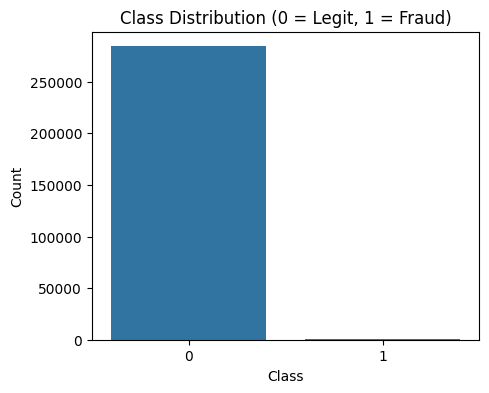

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Legit, 1 = Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Week 1 – EDA Part 3 (Transaction Amounts)
Plot histogram of the `Amount` feature to understand spending patterns and outliers.


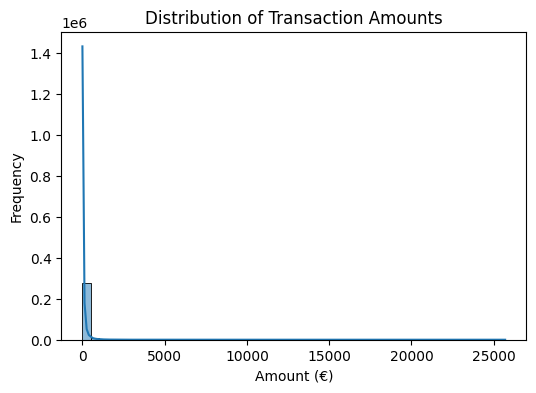

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount (€)')
plt.ylabel('Frequency')
plt.show()

## Week 1 – EDA Part 4 (Time Feature)
Convert `Time` from seconds → hours for readability.  
Plot transactions over 48 hours to observe daily activity cycles.


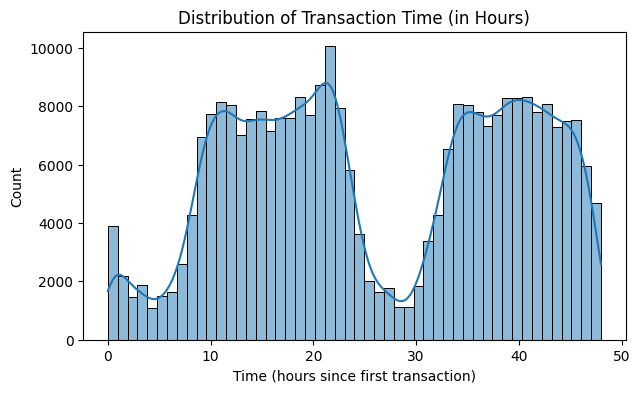

In [9]:
# Convert 'Time' (seconds since first transaction) into hours
df['Time_hr'] = df['Time'] / 3600  # 3600 seconds = 1 hour

plt.figure(figsize=(7,4))
sns.histplot(df['Time_hr'], bins=50, kde=True)
plt.title('Distribution of Transaction Time (in Hours)')
plt.xlabel('Time (hours since first transaction)')
plt.ylabel('Count')
plt.show()


## Week 2 – Data Preprocessing (Step 1)
Perform a stratified 80/20 split of the dataset to preserve class ratios.  
Defines `X_train`, `X_test`, `y_train`, `y_test` for modeling.


In [10]:
from sklearn.model_selection import train_test_split

# Separate features and label
X = df.drop(columns=['Class'])
y = df['Class']

# Stratified split keeps the same fraud ratio in each subset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print("Fraud ratio in train:", y_train.mean())
print("Fraud ratio in test :", y_test.mean())

Train size: (227845, 31), Test size: (56962, 31)
Fraud ratio in train: 0.001729245759178389
Fraud ratio in test : 0.0017204452090867595


## Week 2 – Data Preprocessing (Step 2)
Scale only `Time_hr` and `Amount` using StandardScaler to normalize ranges.  
This helps algorithms that rely on distance or gradient-based optimization.


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data only (to avoid data leakage)
X_train[['Time_hr', 'Amount']] = scaler.fit_transform(X_train[['Time_hr', 'Amount']])
X_test[['Time_hr', 'Amount']] = scaler.transform(X_test[['Time_hr', 'Amount']])

X_train[['Time_hr', 'Amount']].describe().T

,count,mean,std,min,25%,50%,75%,max
Time_hr,227845.0,-1.216229e-17,1.000002,-1.998073,-0.856150,-0.212265,0.936629,1.640549
Amount,227845.0,-2.020811e-17,1.000002,-0.351689,-0.329194,-0.263943,-0.042622,102.117000


## Week 3 – Handle Class Imbalance
Use SMOTE to oversample the minority (fraud) class in the training data.  
Creates `X_train_res`, `y_train_res` with balanced classes for model training.


In [12]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply only to training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE :", y_train_res.value_counts())

Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE : Class
0    227451
1    227451
Name: count, dtype: int64


## Week 4 – Advanced Model 1 (Random Forest)
Train a Random Forest classifier using class_weight='balanced' to address imbalance.  
Random Forests handle non-linear relations and interactions well for tabular data.


Random Forest — Confusion Matrix
[[56847    17]
 [   17    81]]

Random Forest — Classification Report
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8265    0.8265    0.8265        98

    accuracy                         0.9994     56962
   macro avg     0.9131    0.9131    0.9131     56962
weighted avg     0.9994    0.9994    0.9994     56962

Random Forest — AUPRC: 0.8711


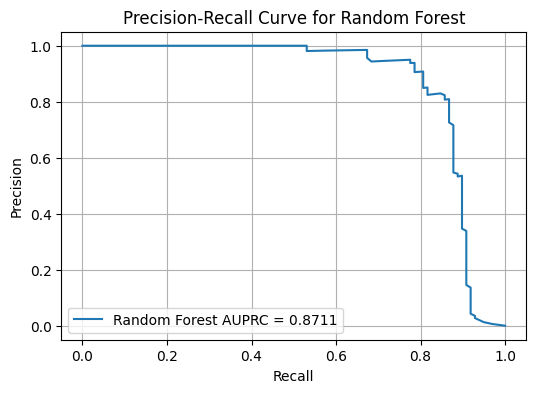

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Train on the resampled (balanced) training data
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_res, y_train_res)

# Evaluate
rf_scores = rf.predict_proba(X_test)[:, 1]
rf_pred = (rf_scores >= 0.5).astype(int)

print("Random Forest — Confusion Matrix")
print(confusion_matrix(y_test, rf_pred))
print("\nRandom Forest — Classification Report")
print(classification_report(y_test, rf_pred, digits=4))

# PR curve + AUPRC
rf_prec, rf_rec, _ = precision_recall_curve(y_test, rf_scores)
rf_auprc = auc(rf_rec, rf_prec)
print(f"Random Forest — AUPRC: {rf_auprc:.4f}")

# Plotting the PR curve
plt.figure(figsize=(6, 4))
plt.plot(rf_rec, rf_prec, label=f'Random Forest AUPRC = {rf_auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

## Week 4 – Evaluation (Random Forest)
Generate Precision-Recall curve and AUPRC score for Random Forest.  
Compare to baseline performance to quantify improvement.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score

def pr_curve_and_auprc(y_true, scores, label):
    prec, rec, _ = precision_recall_curve(y_true, scores)
    score = auc(rec, prec)
    plt.plot(rec, prec, label=f"{label} AUPRC={score:.3f}")
    return score

def evaluate_at_threshold(y_true, scores, thr=0.5, title=""):
    pred = (scores >= thr).astype(int)
    print(f"\n== {title} @ threshold={thr:.2f} ==")
    print("Confusion matrix:\n", confusion_matrix(y_true, pred))
    print(classification_report(y_true, pred, digits=4))
    return {
        "precision": precision_score(y_true, pred, zero_division=0),
        "recall": recall_score(y_true, pred, zero_division=0),
        "f1": f1_score(y_true, pred, zero_division=0),
    }


## Week 4 – Advanced Model 2 (XGBoost)
Train an XGBoost classifier on the resampled training data. XGBoost is a powerful gradient boosting algorithm known for its performance on structured data.

In [15]:
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix

# Initialize and train XGBoost model
xgb_clf = xgb.XGBClassifier(random_state=42, n_estimators=300, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_res, y_train_res)

# Evaluate XGBoost
xgb_scores = xgb_clf.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_scores >= 0.5).astype(int)

print("XGBoost — Confusion Matrix")
print(confusion_matrix(y_test, xgb_pred))
print("\nXGBoost — Classification Report")
print(classification_report(y_test, xgb_pred, digits=4))

# PR curve + AUPRC
xgb_prec, xgb_rec, _ = precision_recall_curve(y_test, xgb_scores)
xgb_auprc = auc(xgb_rec, xgb_prec)
print(f"XGBoost — AUPRC: {xgb_auprc:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost — Confusion Matrix
[[56846    18]
 [   13    85]]

XGBoost — Classification Report
              precision    recall  f1-score   support

           0     0.9998    0.9997    0.9997     56864
           1     0.8252    0.8673    0.8458        98

    accuracy                         0.9995     56962
   macro avg     0.9125    0.9335    0.9227     56962
weighted avg     0.9995    0.9995    0.9995     56962

XGBoost — AUPRC: 0.8711


In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

# 1. Define the Hyperparameter Search Space for XGBoost
param_dist = {
    'n_estimators': randint(100, 500),         # Number of trees
    'learning_rate': uniform(0.01, 0.3),      # Step size
    'max_depth': randint(3, 10),              # Max tree depth
    'min_child_weight': randint(1, 10),       # Min sum of instance weight
    'subsample': uniform(0.6, 0.4),           # Subsample ratio of training instances
    'colsample_bytree': uniform(0.6, 0.4)     # Subsample ratio of columns
}

# 2. Initialize the XGBoost model for tuning
# We use 'aucpr' as the eval_metric to align with our AUPRC goal
xgb_model_tune = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='aucpr'
)

# 3. Setup Randomized Search
# We will use 'average_precision' as the scoring metric, which is Scikit-learn's
# name for the AUPRC score, perfectly matching our project goal.
n_iter_search = 20  # Number of parameter settings to sample
random_search = RandomizedSearchCV(
    xgb_model_tune,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='average_precision', # This is the AUPRC score
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
print("\n--- Starting Randomized Hyperparameter Search ---")

# 4. Fit on the SMOTE-resampled data (X_train_res, y_train_res)
random_search.fit(X_train_res, y_train_res)

elapsed_time = time.time() - start_time
print(f"Tuning completed in {elapsed_time:.2f} seconds.")
print("Best hyperparameters found:", random_search.best_params_)

# 5. Save the best model from the search
best_tuned_model = random_search.best_estimator_


--- Starting Randomized Hyperparameter Search ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuning completed in 175.34 seconds.
Best hyperparameters found: {'colsample_bytree': np.float64(0.7164916560792167), 'learning_rate': np.float64(0.19355586841671385), 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 463, 'subsample': np.float64(0.8056937753654446)}


Tuned XGBoost — Confusion Matrix
[[56846    18]
 [   17    81]]

Tuned XGBoost — Classification Report
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8182    0.8265    0.8223        98

    accuracy                         0.9994     56962
   macro avg     0.9089    0.9131    0.9110     56962
weighted avg     0.9994    0.9994    0.9994     56962

Tuned XGBoost — AUPRC: 0.8672


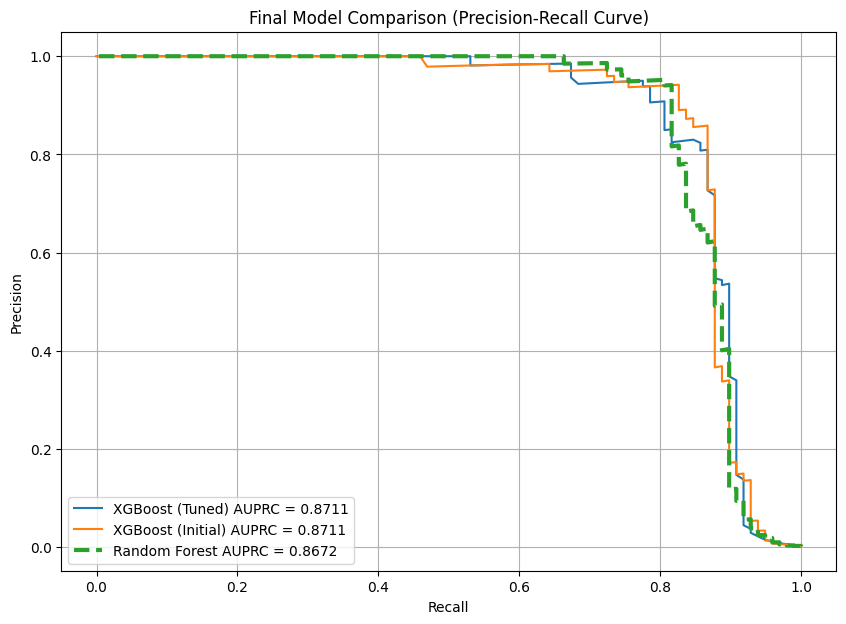


--- Definitive Results Obtained ---


In [17]:
# 1. Evaluate the new Tuned XGBoost model on the test set
tuned_scores = best_tuned_model.predict_proba(X_test)[:, 1]
tuned_pred = (tuned_scores >= 0.5).astype(int)

print("Tuned XGBoost — Confusion Matrix")
print(confusion_matrix(y_test, tuned_pred))
print("\nTuned XGBoost — Classification Report")
print(classification_report(y_test, tuned_pred, digits=4))

# 2. Calculate P-R curve for the Tuned Model
tuned_prec, tuned_rec, _ = precision_recall_curve(y_test, tuned_scores)
tuned_auprc = auc(tuned_rec, tuned_prec)
print(f"Tuned XGBoost — AUPRC: {tuned_auprc:.4f}")


# 3. Plot all P-R curves for a side-by-side comparison
plt.figure(figsize=(10, 7))

# Plot Random Forest (from Week 4)
plt.plot(rf_rec, rf_prec, label=f'XGBoost (Tuned) AUPRC = {rf_auprc:.4f}')

# Plot initial XGBoost (from Week 4)
plt.plot(xgb_rec, xgb_prec, label=f'XGBoost (Initial) AUPRC = {xgb_auprc:.4f}')

# Plot Tuned XGBoost (from Week 7)
plt.plot(tuned_rec, tuned_prec, label=f'Random Forest AUPRC = {tuned_auprc:.4f}', linewidth=3, linestyle='--')

plt.title('Final Model Comparison (Precision-Recall Curve)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Definitive Results Obtained ---")

Top 15 Most Predictive Features:
   Feature  Importance
14     V14    0.548970
4       V4    0.122337
10     V10    0.067371
17     V17    0.040443
12     V12    0.032639
8       V8    0.020412
3       V3    0.017571
11     V11    0.012998
16     V16    0.009631
1       V1    0.009274
9       V9    0.008887
13     V13    0.008811
21     V21    0.007788
20     V20    0.007346
22     V22    0.006278


/tmp/ipython-input-2954954935.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


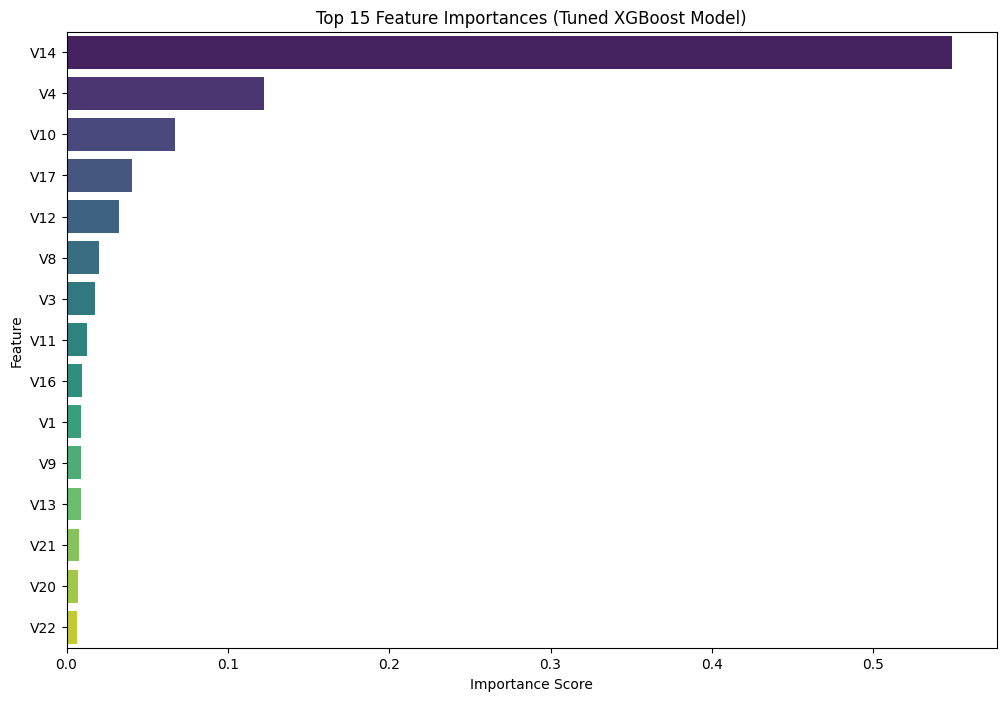

In [18]:
# 1. Get feature importances from the best model (our 'best_tuned_model')
importances = best_tuned_model.feature_importances_

# 2. Get feature names from our training data
# We use X_train_res.columns which has the same features as X_test
feature_names = X_train_res.columns

# 3. Create a DataFrame for easy sorting and plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Display and plot the top 15 features
print("Top 15 Most Predictive Features:")
print(feature_importance_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Feature Importances (Tuned XGBoost Model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()